# Forecasting with Exogenous Variables

In previous tutorial, we saw how to perform univariate time series forecasting using the `sktime` library. In this tutorial, we will extend that knowledge to include forecasting with exogenous variables.


**Duration:** ~10 minutes

## Learning objectives

By the end of this tutorial, you will be able to:
- Work with datasets containing exogenous variables
- Use `fit` and `predict` methods with exogenous variables
- Use `ForecastX` to handle future unknowns in exogenous variables


## 1. Loading Dataset with Exogenous Variables

Let's load a dataset that includes both the target variable and exogenous variables.

As a convention, we usually call `X` the dataframe containing the exogenous variables, and `y` the target variable.


In [4]:
import matplotlib.pyplot as plt

from sktime.datasets import Longley

# Load Longley dataset (economic data with multiple variables)
y, X = Longley().load("y", "X")

y

Period
1947    60323.0
1948    61122.0
1949    60171.0
1950    61187.0
1951    63221.0
1952    63639.0
1953    64989.0
1954    63761.0
1955    66019.0
1956    67857.0
1957    68169.0
1958    66513.0
1959    68655.0
1960    69564.0
1961    69331.0
1962    70551.0
Freq: Y-DEC, Name: TOTEMP, dtype: float64

The `X` dataframe can contain multiple columns, each representing a different exogenous variable. 

In [5]:
X

,GNPDEFL,GNP,UNEMP,ARMED,POP
Period,,,,,
1947,83.0,234289.0,2356.0,1590.0,107608.0
1948,88.5,259426.0,2325.0,1456.0,108632.0
1949,88.2,258054.0,3682.0,1616.0,109773.0
1950,89.5,284599.0,3351.0,1650.0,110929.0
1951,96.2,328975.0,2099.0,3099.0,112075.0
1952,98.1,346999.0,1932.0,3594.0,113270.0
1953,99.0,365385.0,1870.0,3547.0,115094.0
1954,100.0,363112.0,3578.0,3350.0,116219.0
1955,101.2,397469.0,2904.0,3048.0,117388.0


We also need to be careful to ensure that the exogenous variables are aligned with the target variable in terms of time index. The `temporal_train_test_split` function can help us with that, as it will ensure that the training and testing sets are aligned in time.

Here, we assume that we know the future values of the exogenous variables. However, it is common to have usecases where the future values of the exogenous variables are unknown. Later in this tutorial we will see how to easily take that into consideration with sktime API.

In [20]:
from sktime.split.temporal_train_test_split import temporal_train_test_split

# Split the dataset into training and testing sets
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=0.2)

Below, we can see how the exogenous variable visually has some correlation with the target variable, and leveraging it can improve our forecasting performance.

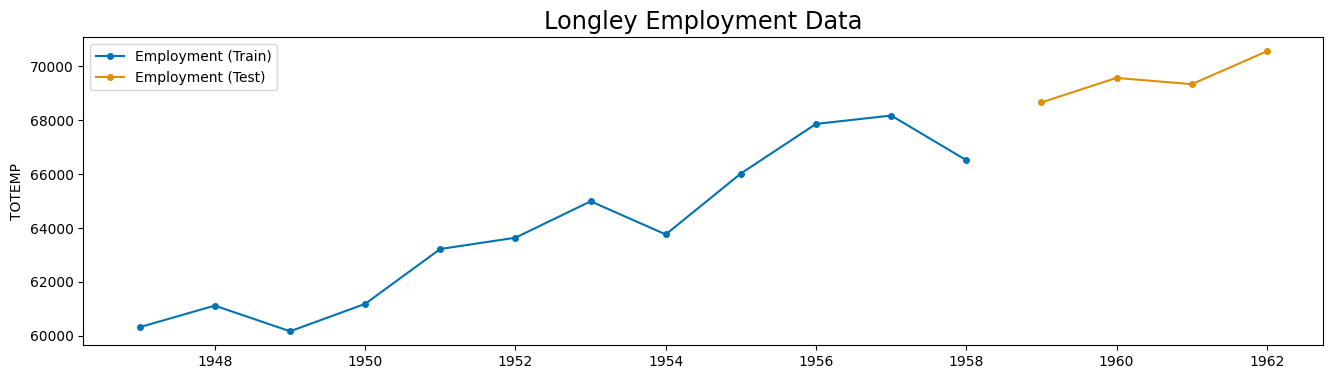

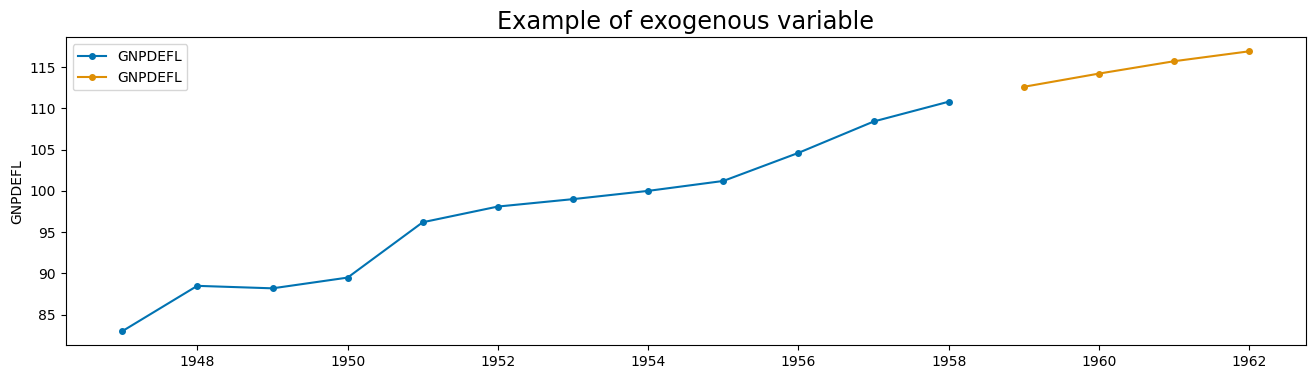

In [21]:
from sktime.utils.plotting import plot_series

plot_series(
    y_train,
    y_test,
    labels=["Employment (Train)", "Employment (Test)"],
    title="Longley Employment Data",
)
plot_series(
    X_train.iloc[:, 0],
    X_test.iloc[:, 0],
    labels=[X_train.columns[0], X_test.columns[0]],
    title="Example of exogenous variable",
)

plt.show()

## 2. sktime Forecasting API: `fit` and `predict`

To use exogenous variables, there are good news: the `fit` and `predict` methods of the forecasting estimators in `sktime` already support exogenous variables. It is straightforward to include them in your forecasting workflow.

* `fit(y, X=None, fh=None)`: The fit method can optionaly take exogenous variables `X`. If `X` is provided, it will be used to fit the model alongside the target variable `y`.
* `predict(fh, X=None)`: Generate forecasts for the specified forecast horizon `fh`, optionally using exogenous variables `X`.


If `X` was provided during fitting, it is necessary to provide it again during prediction.


### 2.1. Future-known Exogenous Variables

After initializing the forecaster, we can fit it to the data using the `fit` method, passing both the target variable `y` and the exogenous variables `X`.

In [40]:
from sktime.forecasting.auto_reg import AutoREG

forecaster = AutoREG(lags=[1, 2])
forecaster.fit(y_train, X=X_train)

AutoREG(lags=[1, 2])

We predict by passing the test indexes as the forecast horizon `fh`, and the exogenous variables `X` for the test set.

In [41]:
y_pred = forecaster.predict(fh=y_test.index, X=X_test)

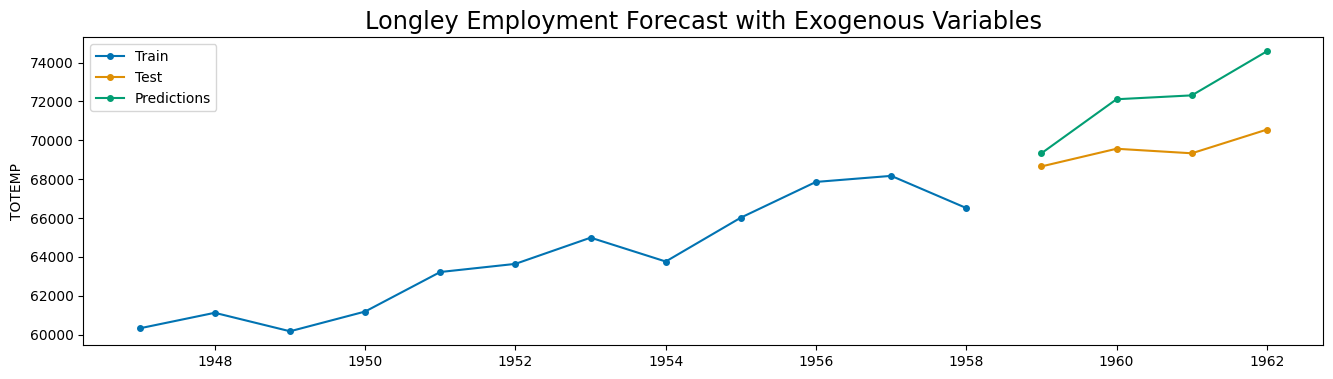

In [42]:
plot_series(
    y_train,
    y_test,
    y_pred,
    labels=["Train", "Test", "Predictions"],
    title="Longley Employment Forecast with Exogenous Variables",
)
plt.show()

We can also do in-sample predictions by passing the training indexes as the forecast horizon `fh`, and the exogenous variables `X` for the training set.

In [43]:
y_pred_insample = forecaster.predict(fh=y_train.index, X=X_train)

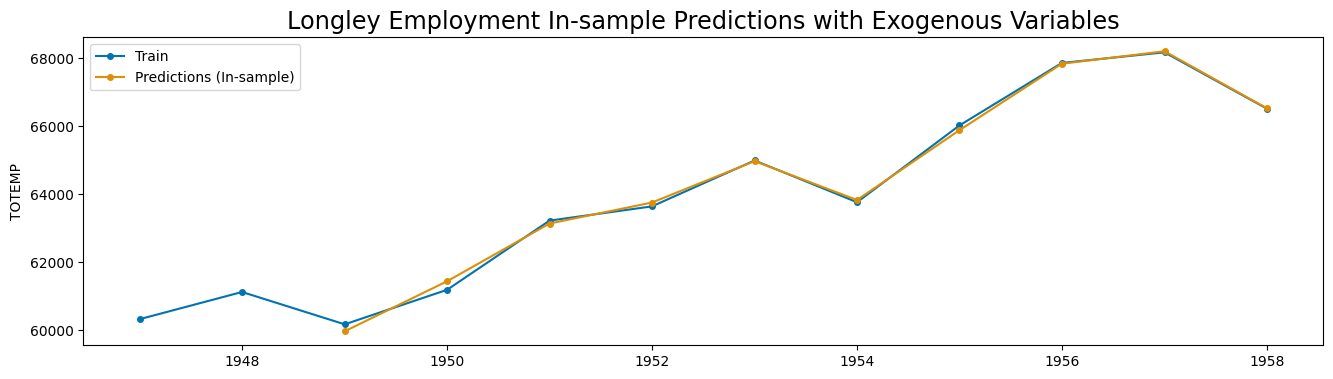

In [44]:
plot_series(
    y_train,
    y_pred_insample,
    labels=["Train", "Predictions (In-sample)"],
    title="Longley Employment In-sample Predictions with Exogenous Variables",
)
plt.show()

### 2.2. Future-unknown Exogenous Variables

To handle cases where the future values of the exogenous variables are unknown, we can use the `ForecastX` class. This class wraps a forecaster for `y` and another for `X`, and internally forecasts the future values of `X` before making predictions for `y`.


In [ ]:
from sktime.forecasting.compose import ForecastX
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

forecaster = ForecastX(
    forecaster_y=AutoREG(lags=[1, 2]), forecaster_X=ExponentialSmoothing(trend="add")
)

forecaster.fit(y_train, X=X_train, fh=y_test.index)

/Users/felipeangelim/.pyenv/versions/sktime-3.11/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


ForecastX(forecaster_X=ExponentialSmoothing(trend='add'),
          forecaster_y=AutoREG(lags=[1, 2]))

This is a type of **composition** of models, one of the features of sktime. In the Pipelines tutorial, we will see how to compose models in a more general way. The interface is always the same:

In [64]:
y_pred_future_unknown = forecaster.predict(fh=y_test.index, X=X_train)
y_pred_future_unknown

1959    56317.160668
1960    57612.911209
1961    61767.817734
1962    63054.101197
Freq: Y-DEC, Name: TOTEMP, dtype: float64

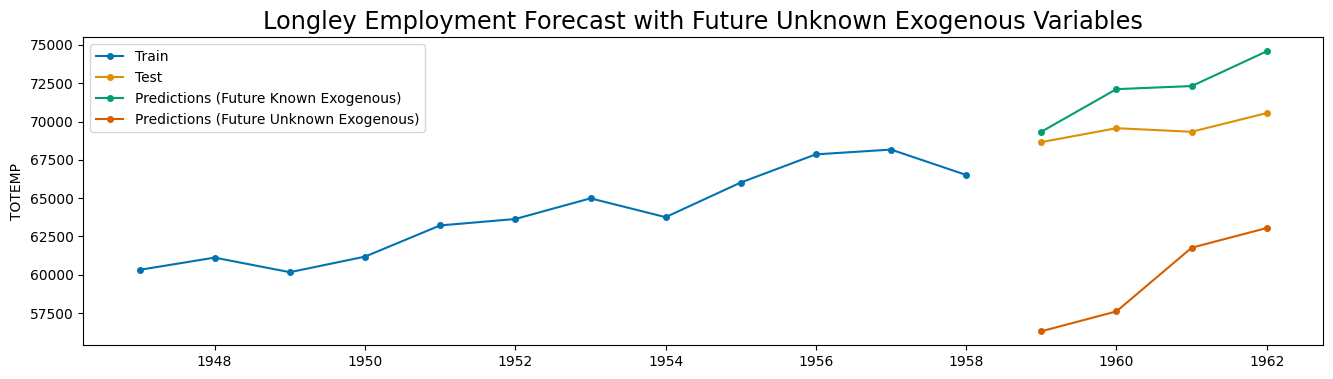

In [63]:
plot_series(
    y_train,
    y_test,
    y_pred,
    y_pred_future_unknown,
    labels=[
        "Train",
        "Test",
        "Predictions (Future Known Exogenous)",
        "Predictions (Future Unknown Exogenous)",
    ],
    title="Longley Employment Forecast with Future Unknown Exogenous Variables",
)
plt.show()

The forecast quality will depend on the quality of the exogenous variables and the forecasting model used for `X`. You can plug your favorite forecasting model for `X` into the `ForecastX` class, and it will handle the forecasting of the exogenous variables internally.

## 3. Finding Forecasters that Support Exogenous Variables

Let's use `all_estimators` to discover which forecasters support exogenous variables.

In [68]:
from sktime.registry import all_estimators

# Get all forecasters that support exogenous variables
all_estimators(
    estimator_types="forecaster",
    filter_tags={"ignores-exogeneous-X": False},
    as_dataframe=True,
)

,name,object
0,ARDL,<class 'sktime.forecasting.ardl.ARDL'>
1,ARIMA,<class 'sktime.forecasting.arima._pmdarima.ARI...
2,AutoARIMA,<class 'sktime.forecasting.arima._pmdarima.Aut...
3,AutoEnsembleForecaster,<class 'sktime.forecasting.compose._ensemble.A...
4,AutoREG,<class 'sktime.forecasting.auto_reg.AutoREG'>
...,...,...
68,UpdateEvery,<class 'sktime.forecasting.stream._update.Upda...
69,UpdateRefitsEvery,<class 'sktime.forecasting.stream._update.Upda...
70,VARMAX,<class 'sktime.forecasting.varmax.VARMAX'>
71,VECM,<class 'sktime.forecasting.vecm.VECM'>


## Key takeaways

* `sktime` supports forecasting with exogenous variables through the `fit` and `predict` methods of forecasting estimators.
* The `ForecastX` class allows for forecasting with future unknown exogenous variables by internally forecasting.
* The library provides a variety of forecasters that can handle exogenous variables, allowing users to choose the best model for their specific use case.